In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#imports for decision tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

#imports for grid search
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

#confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
#read in data
data = pd.read_csv("/Users/Alessa/Desktop/ML/ML Final Project/NHANES_diabetes.csv")

In [3]:
data = data.dropna()

In [4]:
#get feature matrix
Y = np.array(data["Outcome"])
#get feature variables
feature_names = [measure for measure in data.columns if measure != "Outcome" and measure != "SEQN" and measure != "Glucose"]
data_features = data[feature_names]
data_clean = data.drop(columns=["Outcome"])

Xmat = data_features.to_numpy(dtype=np.float64)
#creates classes
class_names = ["0", "1"]

In [5]:
print(feature_names)

['Age', 'Energy', 'Carb', 'Sugar', 'Sleep', 'Systolic', 'Diastolic', 'Pulse']


In [6]:
#preprocess data
#split into train, test, and train data
Xmat_train, Xmat_test, Y_train, Y_test = train_test_split(Xmat, Y, test_size=0.3, random_state=42)

#get validation data
Xmat_train, Xmat_val, Y_train, Y_val = train_test_split(Xmat_train, Y_train, test_size=0.3, random_state=42)

#standardize (note - not standardizing test data)
mean = np.mean(Xmat_train, axis=0)
std = np.std(Xmat_train, axis=0)
Xmat_train = (Xmat_train - mean)/std
Xmat_val = (Xmat_val - mean)/std
#ask - accuracy improved 
Xmat_test = (Xmat_test - mean)/std

#add a column of ones for the intercept term for LR
Xmat_train = np.column_stack((np.ones(len(Xmat_train)), Xmat_train))
Xmat_val = np.column_stack((np.ones(len(Xmat_val)), Xmat_val))
Xmat_test = np.column_stack((np.ones(len(Xmat_test)), Xmat_test))
feature_names = ["intercept"] + feature_names

In [7]:
#accuracy function
def accuracy(Y, Yhat):
    """
    Compute accuracy between true binary labels Y and predicted labels Yhat
    """
    return np.sum(Y == Yhat)/len(Y)

In [8]:
#run logistic regression as a baseline 
model_base = LogisticRegression(solver="lbfgs", class_weight="balanced")
model_base.fit(Xmat_train, Y_train)
print("Accuracy logistic regression", accuracy(Y_test, model_base.predict(Xmat_test)))

Accuracy logistic regression 0.6702619414483821


In [9]:
#print coefficients of LR model
def print_logistic_coefs(feature_names, model):
    """
    Print coefficients from logistic regression
    """
    for f, c in zip(feature_names, model.coef_[0]):
        print(f, round(c, 2))
        
print_logistic_coefs(data_clean.columns, model_base)

SEQN 0.0
Glucose 1.07
Age -0.07
Energy -0.06
Carb 0.02
Sugar -0.21
Sleep 0.07
Systolic -0.03
Diastolic 0.43


In [10]:
#First RandomForest Model
model_forest = RandomForestClassifier(n_estimators=500)
model_forest.fit(Xmat_train, Y_train)
print("Random forest train acc", accuracy(Y_train, model_forest.predict(Xmat_train)), "validation accuracy",accuracy(Y_val, model_forest.predict(Xmat_val)), "test acc", accuracy(Y_test, model_forest.predict(Xmat_test)))

Random forest train acc 1.0 validation accuracy 0.8373626373626374 test acc 0.8628659476117103


In [11]:
descriptive_stats = data.describe()
latex_code = descriptive_stats.to_latex()
print(latex_code)
with open("descriptive_stats.tex", "w") as f:
    f.write(latex_code)

\begin{tabular}{lrrrrrrrrrrr}
\toprule
 & SEQN & Glucose & Outcome & Age & Energy & Carb & Sugar & Sleep & Systolic & Diastolic & Pulse \\
\midrule
count & 2163.000000 & 2163.000000 & 2163.000000 & 2163.000000 & 2163.000000 & 2163.000000 & 2163.000000 & 2163.000000 & 2163.000000 & 2163.000000 & 2163.000000 \\
mean & 98355.810911 & 6.244623 & 0.145169 & 47.775774 & 7.607721 & 2098.374480 & 247.898645 & 105.895834 & 124.492834 & 71.465557 & 0.970411 \\
std & 2702.470620 & 2.009782 & 0.352352 & 19.237287 & 1.642534 & 1002.059902 & 127.908955 & 78.798649 & 19.430164 & 12.777433 & 0.169488 \\
min & 93711.000000 & 2.610000 & 0.000000 & 16.000000 & 2.000000 & 25.000000 & 6.410000 & 1.530000 & 86.000000 & 0.000000 & 0.000000 \\
25% & 95991.500000 & 5.330000 & 0.000000 & 31.000000 & 6.500000 & 1412.000000 & 162.195000 & 54.710000 & 110.000000 & 64.000000 & 1.000000 \\
50% & 98385.000000 & 5.720000 & 0.000000 & 49.000000 & 7.500000 & 1954.000000 & 225.380000 & 89.230000 & 120.000000 & 72.000000 

In [ ]:
#GRIDSEARCH TO FIND BEST MODEL Using Sklearn's GridSearchCV 
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}

#use random forest model created above
grid_search = GridSearchCV(estimator=model_forest, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(Xmat_train, Y_train)

best_params = grid_search.best_params_
print(f"Best Params: {best_params}")
#best model
best_model_forest = grid_search.best_estimator_

#test accuracy
accuracy = best_model_forest.score(Xmat_test,Y_test)
print(f"Accuracy on Test Set: {accuracy:.2f}")

In [ ]:
#FINAL MODEL
final_model_forest = RandomForestClassifier(n_estimators=500, class_weight='balanced_subsample', criterion='log_loss', max_depth=30, min_samples_leaf=1, min_samples_split=2)
final_model_forest.fit(Xmat_train, Y_train)

print("Random forest train acc", accuracy(Y_train, final_model_forest.predict(Xmat_train)), "validation accuracy",accuracy(Y_val, final_model_forest.predict(Xmat_val)), "test acc", accuracy(Y_test, final_model_forest.predict(Xmat_test)))

In [12]:
df_results = pd.DataFrame(grid_search.cv_results_)

NameError: name 'grid_search' is not defined

In [13]:
df_results = df_results.sort_values(by=["rank_test_score"])
df_results = df_results.set_index(
    df_results["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("kernel")
df_results[["params", "rank_test_score", "mean_test_score", "std_test_score"]]
df_results_print = df_results.head(5)

NameError: name 'df_results' is not defined

In [48]:
latex_code = df_results_print[["params", "rank_test_score", "mean_test_score", "std_test_score"]].to_latex(
    index=False,
    escape=False,
    float_format="%.4f",
)
print(latex_code)

\begin{tabular}{lrrr}
\toprule
params & rank_test_score & mean_test_score & std_test_score \\
\midrule
{'class_weight': 'balanced', 'criterion': 'log_loss', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500} & 1 & 0.8470 & 0.0115 \\
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500} & 2 & 0.8461 & 0.0094 \\
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100} & 3 & 0.8451 & 0.0063 \\
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200} & 4 & 0.8451 & 0.0065 \\
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300} & 4 & 0.8451 & 0.0107 \\
\bottomrule
\end{tabular}



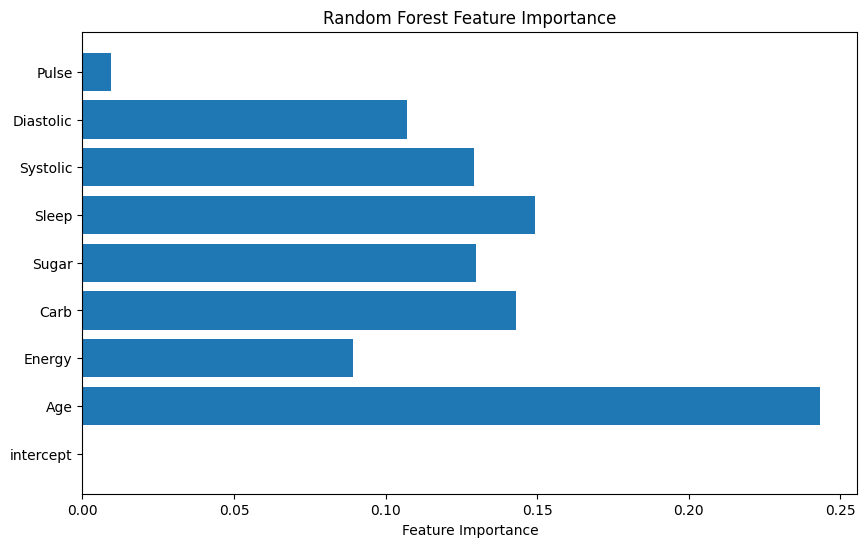

In [76]:
#Display important features of Random Forest Model
feature_importances = final_model_forest.feature_importances_

#use python matlab plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances, align="center")
plt.yticks(np.arange(len(feature_names)), feature_names)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.savefig("rf.png")
plt.show()

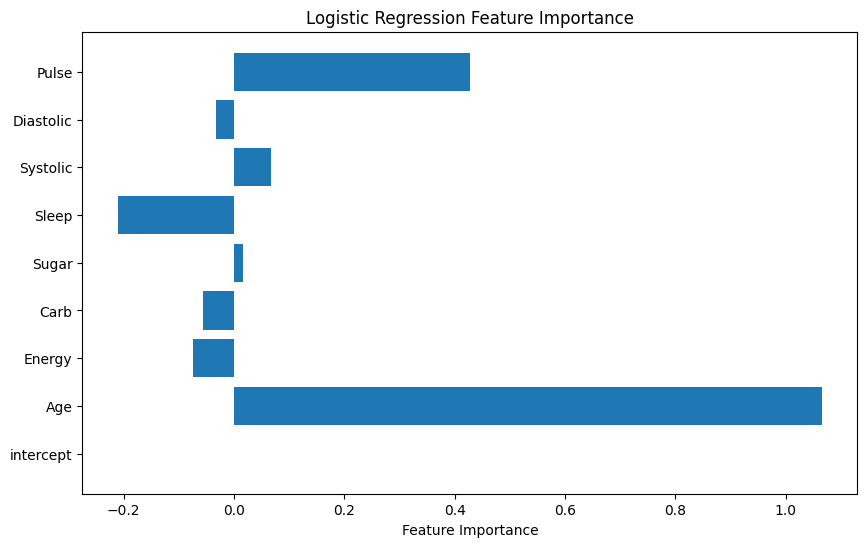

In [75]:
#show coefficients from logistic regression to show important feature
feature_importances = model_base.coef_.flatten()

plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances, align="center")
plt.yticks(np.arange(len(feature_names)), feature_names)
plt.xlabel("Feature Importance")
plt.title("Logistic Regression Feature Importance")
plt.savefig("lg.png")
plt.show()

In [83]:
#Abilation Study - removing age
#get feature matrix
Y = np.array(data["Outcome"])
feature_names_a = [measure for measure in data.columns if measure != "Outcome" and measure != "SEQN" and measure != "Glucose" and measure !="Age"]
data_features_a = data[feature_names_a]

Xmat_a = data_features_a.to_numpy(dtype=np.float64)

In [86]:
#Abiliation Study cont.
#preprocess data
#split into train, test, and train data
Xmat_train_a, Xmat_test_a, Y_train_a, Y_test_a = train_test_split(Xmat_a, Y, test_size=0.3, random_state=42)

#get validation data
Xmat_train_a, Xmat_val_a, Y_train_a, Y_val_a = train_test_split(Xmat_train_a, Y_train_a, test_size=0.3, random_state=42)

#standardize (note - not standardizing test data)
mean_a = np.mean(Xmat_train_a, axis=0)
std_a = np.std(Xmat_train_a, axis=0)
Xmat_train_a = (Xmat_train_a - mean_a)/std_a
Xmat_val_a = (Xmat_val_a - mean_a)/std_a
#ask - accuracy improved 
Xmat_test_a = (Xmat_test_a - mean_a)/std_a

#add a column of ones for the intercept term
Xmat_train_a = np.column_stack((np.ones(len(Xmat_train_a)), Xmat_train_a))
Xmat_val_a = np.column_stack((np.ones(len(Xmat_val_a)), Xmat_val_a))
Xmat_test_a = np.column_stack((np.ones(len(Xmat_test_a)), Xmat_test_a))
feature_names_abilation = ["intercept"] + feature_names_abilation

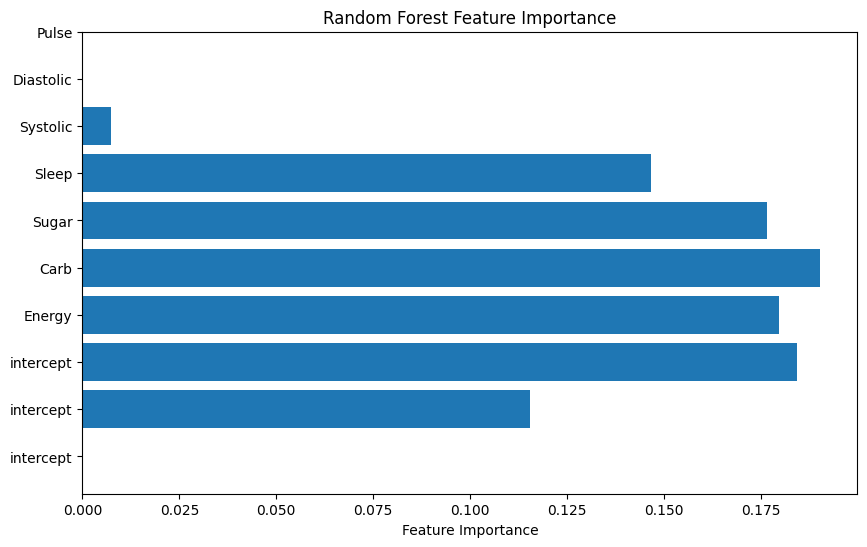

Random forest train acc 1.0 validation accuracy 0.8373626373626374 test acc 0.8659476117103235


In [90]:
#Abilation Model - w same params as final RF model
final_model_forest_a = RandomForestClassifier(n_estimators=500, class_weight='balanced_subsample', criterion='log_loss', max_depth=30, min_samples_leaf=1, min_samples_split=2)
final_model_forest_a.fit(Xmat_train_a, Y_train_a)
feature_importances = final_model_forest_a.feature_importances_

plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances, align="center")
plt.yticks(np.arange(len(feature_names_abilation)), feature_names_abilation)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.savefig("rf.png")
plt.show()

print("Random forest train acc", accuracy(Y_train_a, final_model_forest_a.predict(Xmat_train_a)), "validation accuracy",accuracy(Y_val_a, final_model_forest_a.predict(Xmat_val_a)), "test acc", accuracy(Y_test_a, final_model_forest_a.predict(Xmat_test_a)))

In [96]:
#Abilation Study - removing pulse
#get feature matrix
Y = np.array(data["Outcome"])
feature_names_p = [measure for measure in data.columns if measure != "Outcome" and measure != "SEQN" and measure != "Glucose" and measure !="Pulse"]
data_features_p = data[feature_names_p]

Xmat_p = data_features_p.to_numpy(dtype=np.float64)

In [98]:
#Abiliation Study cont.
#preprocess data
#split into train, test, and train data
Xmat_train_p, Xmat_test_p, Y_train_p, Y_test_p = train_test_split(Xmat_p, Y, test_size=0.3, random_state=42)

#get validation data
Xmat_train_p, Xmat_val_p, Y_train_p, Y_val_p = train_test_split(Xmat_train_p, Y_train_p, test_size=0.3, random_state=42)

#standardize (note - not standardizing test data)
mean_p = np.mean(Xmat_train_p, axis=0)
std_p = np.std(Xmat_train_p, axis=0)
Xmat_train_p = (Xmat_train_p - mean_p)/std_p
Xmat_val_p = (Xmat_val_p - mean_p)/std_p
#ask - accuracy improved 
Xmat_test_p = (Xmat_test_p - mean_p)/std_p

#add a column of ones for the intercept term
Xmat_train_p = np.column_stack((np.ones(len(Xmat_train_p)), Xmat_train_p))
Xmat_val_p = np.column_stack((np.ones(len(Xmat_val_p)), Xmat_val_p))
Xmat_test_p = np.column_stack((np.ones(len(Xmat_test_p)), Xmat_test_p))
feature_names_p = ["intercept"] + feature_names_p

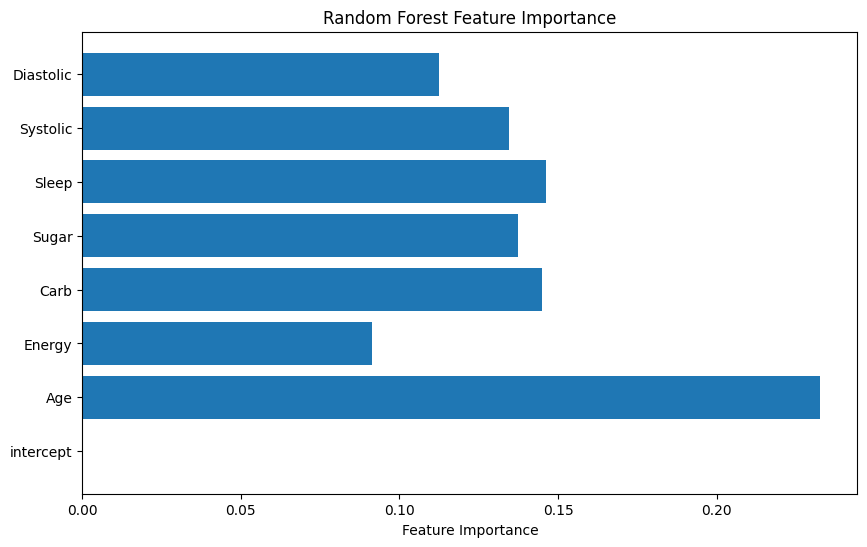

Random forest train acc 1.0 validation accuracy 0.8373626373626374 test acc 0.8705701078582434


In [104]:
#Abilation Model - w same params as final RF model
final_model_forest_p = RandomForestClassifier(n_estimators=500, class_weight='balanced_subsample', criterion='log_loss', max_depth=30, min_samples_leaf=1, min_samples_split=2)
final_model_forest_p.fit(Xmat_train_p, Y_train_p)
feature_importances_p = final_model_forest_p.feature_importances_

plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances_p)), feature_importances_p, align="center")
plt.yticks(np.arange(len(feature_names_p)), feature_names_p)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.savefig("rf.png")
plt.show()

print("Random forest train acc", accuracy(Y_train_p, final_model_forest_p.predict(Xmat_train_p)), "validation accuracy",accuracy(Y_val_p, final_model_forest_p.predict(Xmat_val_p)), "test acc", accuracy(Y_test_p, final_model_forest_p.predict(Xmat_test_p)))

In [101]:
df_results.tail(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
kernel,,,,,,,,,,,,,,,,,,,
balanced_log_loss_10_4_5_400,1.282278,0.020088,0.041405,0.002744,balanced,log_loss,10,4,5,400,"{'class_weight': 'balanced', 'criterion': 'log...",0.787736,0.801887,0.773585,0.768868,0.786730,0.783761,0.011649,536
balanced_entropy_10_2_10_200,0.790333,0.048186,0.023462,0.002460,balanced,entropy,10,2,10,200,"{'class_weight': 'balanced', 'criterion': 'ent...",0.773585,0.792453,0.759434,0.801887,0.786730,0.782818,0.014858,537
balanced_log_loss_10_4_10_100,0.310813,0.005024,0.011636,0.001946,balanced,log_loss,10,4,10,100,"{'class_weight': 'balanced', 'criterion': 'log...",0.778302,0.801887,0.768868,0.778302,0.781991,0.781870,0.010911,538
balanced_entropy_10_4_10_200,0.716270,0.015808,0.023071,0.003517,balanced,entropy,10,4,10,200,"{'class_weight': 'balanced', 'criterion': 'ent...",0.773585,0.797170,0.759434,0.792453,0.781991,0.780926,0.013518,539
balanced_log_loss_10_4_10_200,0.623675,0.025011,0.021439,0.002246,balanced,log_loss,10,4,10,200,"{'class_weight': 'balanced', 'criterion': 'log...",0.764151,0.783019,0.773585,0.773585,0.805687,0.780005,0.014159,540


In [102]:
#Abilation Study - removing carb
#get feature matrix
Y = np.array(data["Outcome"])
feature_names_c = [measure for measure in data.columns if measure != "Outcome" and measure != "SEQN" and measure != "Glucose" and measure !="Carb"]
data_features_c = data[feature_names_c]

Xmat_c = data_features_c.to_numpy(dtype=np.float64)

In [103]:
#Abiliation Study cont.
#preprocess data
#split into train, test, and train data
Xmat_train_c, Xmat_test_c, Y_train_c, Y_test_c = train_test_split(Xmat_c, Y, test_size=0.3, random_state=42)

#get validation data
Xmat_train_c, Xmat_val_c, Y_train_c, Y_val_c = train_test_split(Xmat_train_c, Y_train_c, test_size=0.3, random_state=42)

#standardize (note - not standardizing test data)
mean_c = np.mean(Xmat_train_c, axis=0)
std_c = np.std(Xmat_train_c, axis=0)
Xmat_train_c = (Xmat_train_c - mean_c)/std_c
Xmat_val_c = (Xmat_val_c - mean_c)/std_c
#ask - accuracy improved 
Xmat_test_c = (Xmat_test_c - mean_c)/std_c

#add a column of ones for the intercept term
Xmat_train_c = np.column_stack((np.ones(len(Xmat_train_c)), Xmat_train_c))
Xmat_val_c = np.column_stack((np.ones(len(Xmat_val_c)), Xmat_val_c))
Xmat_test_c = np.column_stack((np.ones(len(Xmat_test_c)), Xmat_test_c))
feature_names_c = ["intercept"] + feature_names_c

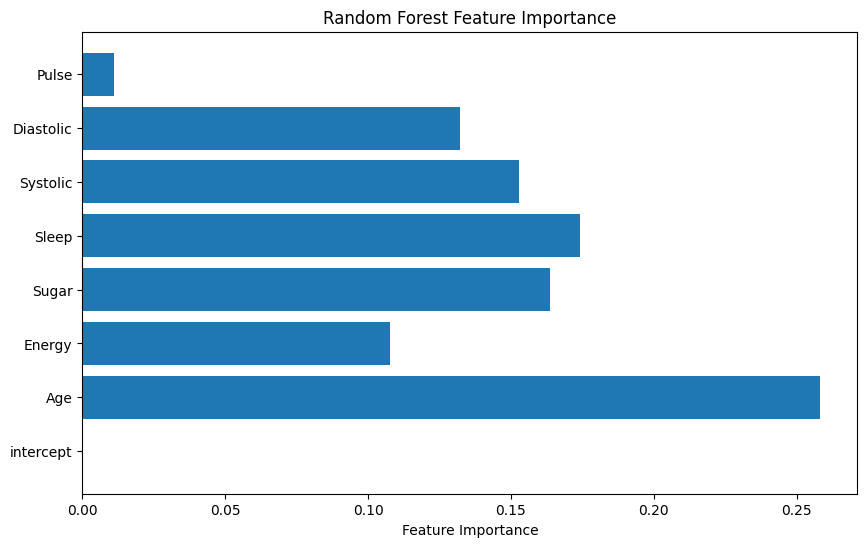

Random forest train acc 1.0 validation accuracy 0.8373626373626374 test acc 0.8659476117103235


In [105]:
#Abilation Model - w same params as final RF model
final_model_forest_c = RandomForestClassifier(n_estimators=500, class_weight='balanced_subsample', criterion='log_loss', max_depth=30, min_samples_leaf=1, min_samples_split=2)
final_model_forest_c.fit(Xmat_train_c, Y_train_c)
feature_importances_c = final_model_forest_c.feature_importances_

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances_c)), feature_importances_c, align="center")
plt.yticks(np.arange(len(feature_names_c)), feature_names_c)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.savefig("rf.png")
plt.show()

print("Random forest train acc", accuracy(Y_train_c, final_model_forest_c.predict(Xmat_train_c)), "validation accuracy",accuracy(Y_val_c, final_model_forest_c.predict(Xmat_val_c)), "test acc", accuracy(Y_test_c, final_model_forest_c.predict(Xmat_test_c)))

In [109]:
y_pred = final_model_forest.predict(Xmat_test)
confusion_matrix(Y_test, y_pred)

array([[557,   8],
       [ 78,   6]])

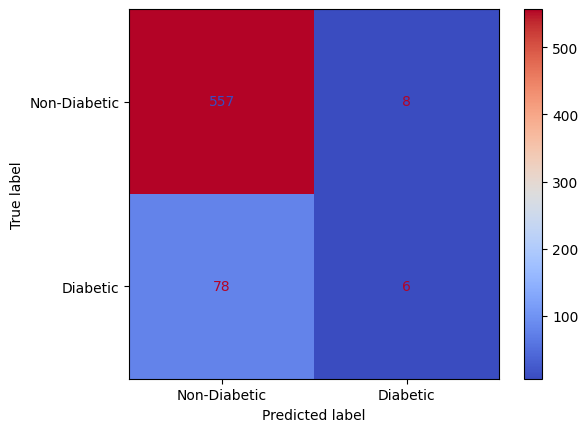

In [117]:
cm = ConfusionMatrixDisplay(confusion_matrix(Y_test, y_pred), display_labels=["Non-Diabetic", "Diabetic"])
cm.plot(cmap="coolwarm") 
plt.savefig("confusion.png")
plt.show()